In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#exceção Cross Validation do sklearn
from sklearn.model_selection import cross_val_score 

from g_ml.utilidades.processamento import treino_teste
from g_ml.utilidades.processamento import escala_padrao

from g_ml.utilidades.metricas import ACC
from g_ml.utilidades.metricas import relatorio_classificacao
from g_ml.utilidades.metricas import ValCruzada

from g_ml.algoritmos.classificacao import RegressaoLogistica
from g_ml.algoritmos.classificacao import ADG







In [2]:
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True)

In [3]:
# Separação em treino e teste
X_treino, X_teste, y_treino, y_teste = treino_teste(X, y, tamanho_teste = 0.33)

In [4]:
escalador_X = escala_padrao()

escalador_X.fit(X_treino)

X_treino_escalado = escalador_X.transform(X_treino)
X_teste_escalado = escalador_X.transform(X_teste)

In [5]:
## Modelo dumb para baseline

In [6]:
np.unique(y_treino, return_counts=True)

(array([0, 1]), array([144, 238], dtype=int64))

In [7]:
y_base = np.ones(len(y_teste))
print("A acurácia base de um modelo inocente é: {}".format(ACC(y_base, y_teste)))

A acurácia base de um modelo inocente é: 0.6363636363636364


# Regressão Logística com Gradiente Descendente

In [8]:
RL = RegressaoLogistica()
RL.fit(X_treino_escalado, y_treino)
y_pred = RL.predict(X_teste_escalado)
print(ACC(y_teste,y_pred))


0.8288770053475936


In [9]:
RL.w

array([-1.26235715, -1.13154191, -0.88365622, -1.58558964, -1.45971969,
       -0.92810006, -0.87684951, -1.12366601, -1.18597053, -1.46710755,
       -1.40944375, -1.65308081, -1.00075741, -1.70242985, -1.41922402,
       -1.61126596, -1.14707027, -1.19954475, -1.20404146, -1.26504904,
       -1.32959608, -1.03040906, -1.29431203, -1.2905267 , -1.2572208 ,
       -0.9928518 , -0.843473  , -1.49421864, -1.5613216 , -1.67069606,
       -1.59100347])

In [10]:
scores = relatorio_classificacao(y_pred, y_teste)

In [11]:
scores.print_scores()

A acurácia do modelo é de: 0.8288770053475936 
A precisão do modelo é de: 0.9142857142857143
A revocacão do modelo é de: 0.8067226890756303
O f1_score do modelo é de: 0.857142857142857


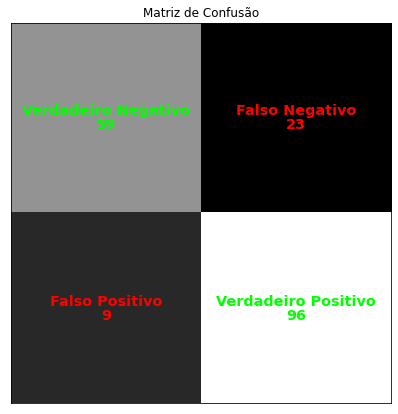

In [12]:
scores.plot_scores()

In [13]:
## TESTE
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_treino_escalado, y_treino)
y_pred2 = model.predict(X_teste_escalado)
print(accuracy_score(y_pred2,y_teste))

0.9786096256684492


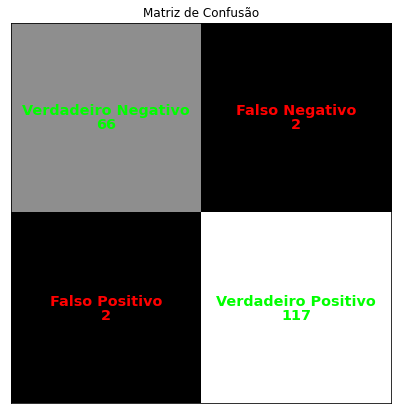

In [14]:
scores = relatorio_classificacao(y_pred2, y_teste)
scores.plot_scores()


# Análise de Discriminante Gaussiano

In [15]:
adg = ADG()
adg.fit(X_treino_escalado, y_treino)
y_pred = adg.predict(X_teste_escalado)
print(ACC(y_pred, y_teste))

0.93048128342246


In [16]:
scores = relatorio_classificacao(y_pred, y_teste)
scores.print_scores()

A acurácia do modelo é de: 0.93048128342246 
A precisão do modelo é de: 0.9732142857142857
A revocacão do modelo é de: 0.9159663865546218
O f1_score do modelo é de: 0.9437229437229437


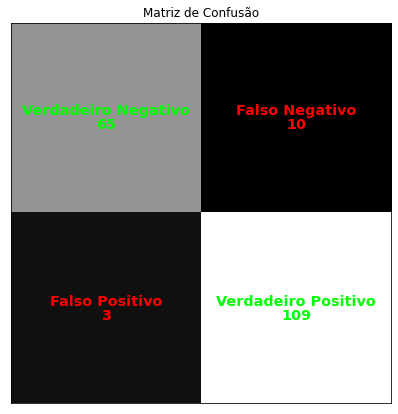

In [17]:
scores.plot_scores()

# Validação Cruzada

In [18]:
class VC():
    
    def __init__(self, X ,part=10):
        # Ao inicializar ele salva os índices das partições aleatórias dos dados
        # Para que sejam usados as mesmas entradas para diferentes modelos e técnicas de pré-processamento
        
        self.part = part
        self.indice_aleatorio = np.random.permutation(len(X))
        
        self.X_folds = None
        self.y_folds = None
        
        self.X_testes = None
        self.X_treinos = None
        self.y_testes = None
        self.y_treinos = None
        
        self.preds = None
        self.acc = None
        self.precisao = None
        self.revocacao = None
        self.f1_score = None
          
    def particionar(self, X, y):
        # Esse método separa os dados em seus devidos conjuntos de treino e teste para cada uma das partições. 
        
        self.X_folds = []
        self.y_folds = []
        
        self.X_testes = []
        self.X_treinos = []
        self.y_testes = []
        self.y_treinos = []
        
        _X = X[self.indice_aleatorio].copy()
        _y = y[self.indice_aleatorio].copy()
        index = np.floor(np.linspace(0,len(_X), self.part+1)).astype('int')
        
        for i in range(self.part):
            start = index[i]
            end = index[i+1]
            self.X_folds.append(_X[start:end,:])
            self.y_folds.append(_y[start:end])
            
        for i in range(len(self.X_folds)):
            _X_folds = self.X_folds.copy()
            _y_folds = self.y_folds.copy()
            
            self.X_testes.append(_X_folds.pop(i))
            self.X_treinos.append(np.concatenate(_X_folds,axis=0))
            
            self.y_testes.append(_y_folds.pop(i))
            self.y_treinos.append(np.concatenate(_y_folds))
            
            
            
    def medir(self, modelo):
        # Calcula as predições, as métricas e estatísticas para cada partição.
        
        self.preds = []
        self.acc = []
        self.precisao = []
        self.revocacao = []
        self.f1_score = []
        
        for i in range(self.part):
            modelo.fit(self.X_treinos[i], self.y_treinos[i])
            self.preds.append(modelo.predict(self.X_testes[i]))
        
        for i in range(self.part):
            metricas = relatorio_classificacao(self.preds[i], vc.y_testes[i])
            self.acc.append(metricas.acc)
            self.precisao.append(metricas.precisao)
            self.revocacao.append(metricas.revocacao)
            self.f1_score.append(metricas.f1_score)
            
        print("Acurácia média é: {} e seu desvio padrão é: {} ".format(np.mean(self.acc),np.std(self.acc)))
        print("Precisão média é: {} e seu desvio padrão é: {} ".format(np.mean(self.precisao),np.std(self.precisao)))
        print("Revocacão média é: {} e seu desvio padrão é: {} ".format(np.mean(self.revocacao),np.std(self.revocacao)))
        print("F1_score médio é: {} e seu desvio padrão é: {} ".format(np.mean(self.f1_score),np.std(self.f1_score)))            
        
        
                
                
        

    
    
    
        

In [19]:
vc = VC(X_treino, part= 10)

In [20]:
vc.particionar(X_treino_escalado, y_treino)

In [21]:
vc.medir(ADG())

Acurácia média é: 0.9370445344129553 e seu desvio padrão é: 0.0267244813836882 
Precisão média é: 0.9916666666666668 e seu desvio padrão é: 0.016877912950902185 
Revocacão média é: 0.9092068824894912 e seu desvio padrão é: 0.04036113158116526 
F1_score médio é: 0.9480282339325219 e seu desvio padrão é: 0.021076705779426094 


In [22]:
VC = ValCruzada(X_treino, part= 10)
VC.particionar(X_treino_escalado, y_treino)
VC.medir(ADG())


Acurácia média é: 0.942375168690958 e seu desvio padrão é: 0.03485623840890625 
Precisão média é: 0.9872878787878788 e seu desvio padrão é: 0.019458279873806487 
Revocacão média é: 0.9214033575543873 e seu desvio padrão é: 0.039456437872989095 
F1_score médio é: 0.952841986717781 e seu desvio padrão é: 0.026457671514645346 


In [23]:
acc = []
precisao = []
revocacao = []
f1_score = []
for i in range(vc.part):
    metricas = relatorio_classificacao(vc.preds[i], vc.y_testes[i])
    acc.append(metricas.acc)
    precisao.append(metricas.precisao)
    revocacao.append(metricas.revocacao)
    f1_score.append(metricas.f1_score)
    
    

In [24]:
vc.preds

[array([1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1]),
 array([1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]),
 array([0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1]),
 array([0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
        1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0]),
 array([1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0]),
 array([0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0]),
 array([1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]),
 array([0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,

In [25]:
f1_score

[0.9583333333333334,
 0.923076923076923,
 0.9523809523809523,
 0.9333333333333333,
 1.0,
 0.9523809523809523,
 0.9310344827586207,
 0.9583333333333334,
 0.9411764705882353,
 0.9302325581395349]

In [26]:
len(vc.folds)

AttributeError: 'VC' object has no attribute 'folds'

In [ ]:
indice_aleatorio = np.random.permutation(len(X))

In [ ]:
np.random.permutation?

In [ ]:
_X = X[indice_aleatorio].copy()

In [ ]:
_X = X.copy()

In [ ]:
np.random.shuffle(_X)

In [ ]:
index = np.floor(np.linspace(0,len(_X),10)).astype('int')

In [ ]:
index

In [ ]:
folds = []
for i in range(9):
    start = index[i]
    end = index[i+1]
    folds.append(_X[start:end,:])
    
    

In [ ]:
_folds = folds.copy()
teste = _folds.pop(0)
treino = np.concatenate(_folds,axis=0)


In [ ]:
indice_aleatorio = np.random.permutation(len(y))

In [ ]:
indice_aleatorio